In [1]:
import sys

#sys.path.insert(0, 'backend_functions')

#import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

from matplotlib import gridspec


Welcome to JupyROOT 6.24/02


In [2]:
ending = "Jan19_MECTune"

In [3]:
##Regular tune prior true and smearcept to be used


#Recall for comparison it will be the MEC tune for prior true

In [4]:
####Load in MECTune full event counts

nue_data_signal = pd.read_csv("nue_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

nue_data_signal = nue_data_signal.values[:, 0]

print(nue_data_signal)
print("")

######

numu_data_signal = pd.read_csv("numu_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

numu_data_signal = numu_data_signal.values[:, 0]

print(numu_data_signal)

[  2.38771548   3.36090025   4.07975694   8.68619826   9.68867537
  11.05054344  14.87176831  25.90293794  49.4253173  149.99758453]

[  57.2325191    44.82742995   59.02327659   76.11232753   87.1915794
  147.03185493  205.63440389  318.68880869  601.9700348  1177.11559803]


In [5]:
###Load in regular tune bkg event counts
#Include ext in bkg count here as the full event counts do

ending = "Jan19" #need this ending as bkg is from regular tune



nue_bkg_inc_ext = pd.read_csv("nue_nopions_angleDiff_usingSelection_comb_cv_nue_bkg_incExt_"+ending+".csv", header=None)

nue_bkg_inc_ext = nue_bkg_inc_ext.values[:, 0]

print(nue_bkg_inc_ext)
print("")

#######################

numu_bkg_inc_ext = pd.read_csv("numu_nopions_angleDiff_usingSelection_comb_cv_numu_bkg_incExt_"+ending+".csv", header=None)

numu_bkg_inc_ext = numu_bkg_inc_ext.values[:, 0]

print(numu_bkg_inc_ext)
print("")

[ 1.125004    1.3636628   1.93697273  4.85652612  3.56279372  4.10128825
  3.68560034  6.46732686 11.84780336 40.86414887]

[ 21.63167491  13.5363924   12.56102384  13.12996887  18.81793676
  36.03563436  54.47993438  87.76891513 173.57981138 357.68668115]



In [6]:
####So then can calculate the data signal input to the unfolding

nue_datasig_bkg_subtracted = nue_data_signal - nue_bkg_inc_ext
print(nue_datasig_bkg_subtracted)
print("")

numu_datasig_bkg_subtracted = numu_data_signal - numu_bkg_inc_ext
print(numu_datasig_bkg_subtracted)

[  1.26271148   1.99723746   2.14278421   3.82967214   6.12588165
   6.94925519  11.18616796  19.43561108  37.57751394 109.13343566]

[ 35.60084419  31.29103754  46.46225275  62.98235867  68.37364264
 110.99622058 151.15446951 230.91989356 428.39022342 819.42891688]


In [7]:
nue_numu_tot = np.concatenate((nue_datasig_bkg_subtracted, numu_datasig_bkg_subtracted), axis=0)

print(nue_numu_tot)
print(len(nue_numu_tot))

[  1.26271148   1.99723746   2.14278421   3.82967214   6.12588165
   6.94925519  11.18616796  19.43561108  37.57751394 109.13343566
  35.60084419  31.29103754  46.46225275  62.98235867  68.37364264
 110.99622058 151.15446951 230.91989356 428.39022342 819.42891688]
20


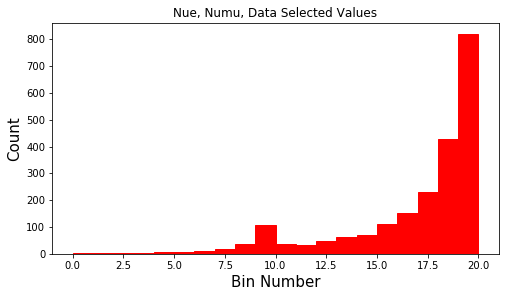

In [8]:
nue_numu_fig = plt.figure(figsize=(8, 7))
nue_numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_numu_ax1 = plt.subplot(nue_numu_gs[0])


#bins = np.arange(0, 10.5, 0.5)
#count = np.linspace(0.1, 9.6, 20)
bins = np.arange(0, 21, 1)
count = np.arange(0.0, 20.0, 1)


sel_ratio = nue_numu_ax1.hist(count, bins, edgecolor='red', facecolor='red', weights=nue_numu_tot)
nue_numu_ax1.set_ylabel('Count', fontsize=15)
nue_numu_ax1.set_xlabel('Bin Number', fontsize=15)
nue_numu_ax1.set_title("Nue, Numu, Data Selected Values")
#leg = nue_numu_ax1.legend()
#nue_numu_ax1.set_ylim([0, 1])

nue_numu_fig.savefig("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

In [9]:
np.savetxt("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
               nue_numu_tot,
               delimiter =", ", 
               fmt ='% s')

print(ending)

Jan19


In [10]:
####Now need to get in the uncertainties

###First up, get the noTune statistical uncertinaty. This will be from sig + bkg in noTune

ending = "Jan19_MECTune" 


nue_sig_unc = pd.read_csv("nue_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

nue_sig_unc = nue_sig_unc.values[:, 0]

print(nue_sig_unc)
print("")

########################

numu_sig_unc = pd.read_csv("numu_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

numu_sig_unc = numu_sig_unc.values[:, 0]

print(numu_sig_unc)
print("")

#######################The regular tune bkg stat uncertainties

ending = "Jan19" #need this ending as bkg is from regular tune


nue_bkg_unc = pd.read_csv("nue_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

nue_bkg_unc = nue_bkg_unc.values[:, 0]

print(nue_bkg_unc)
print("")

########################

numu_bkg_unc = pd.read_csv("numu_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

numu_bkg_unc = numu_bkg_unc.values[:, 0]

print(numu_bkg_unc)
print("")

[ 0.49171135  0.42840553  1.16143552  2.16666775  1.35295846  1.67200542
  1.37653703  2.26299881  3.96051443 16.91143086]

[  17.11518939   11.42448771   22.032146     33.95799117   27.05823194
  112.17960578  127.63059934  213.82845357  512.36903969 1441.50046608]

[0.40361937 0.37869795 1.09248271 1.87785601 1.11476086 1.52469818
 0.87277381 1.16674332 1.48117631 5.47838269]

[ 5.56527103  3.31864546  4.92737201  3.85884493  6.41568387 16.33395278
 23.07504552 32.3956967  55.28743915 96.00956256]



In [11]:
nue_stat_unc = nue_sig_unc + nue_bkg_unc
print(nue_stat_unc)
print("")

########################

numu_stat_unc = numu_sig_unc + numu_bkg_unc
print(numu_stat_unc)
print("")

#########################

nue_numu_tot_unc = np.concatenate((nue_stat_unc, numu_stat_unc), axis=0)

print(nue_numu_tot_unc)

[ 0.89533072  0.80710349  2.25391823  4.04452376  2.46771932  3.19670359
  2.24931084  3.42974214  5.44169074 22.38981354]

[  22.68046042   14.74313317   26.95951801   37.81683611   33.47391581
  128.51355856  150.70564486  246.22415027  567.65647885 1537.51002864]

[8.95330717e-01 8.07103486e-01 2.25391823e+00 4.04452376e+00
 2.46771932e+00 3.19670359e+00 2.24931084e+00 3.42974214e+00
 5.44169074e+00 2.23898135e+01 2.26804604e+01 1.47431332e+01
 2.69595180e+01 3.78168361e+01 3.34739158e+01 1.28513559e+02
 1.50705645e+02 2.46224150e+02 5.67656479e+02 1.53751003e+03]


In [12]:
nue_numu_cov_stats   = np.zeros([(len(bins)-1), (len(bins)-1)])
print(nue_numu_cov_stats)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [13]:
nue_numu_cov_stats[np.diag_indices_from(nue_numu_cov_stats)]    = nue_numu_tot_unc

In [14]:
###Then sprinkle in the regular tune genie sys uncertainties

# Load in the blockwise genie cov matrix

blockwise_genie_err = pd.read_csv("blockwise_cov_genie_only_angle_comb_"+ending+".csv", header=None)

blockwise_genie_err = blockwise_genie_err.values
print(blockwise_genie_err)

[[ 1.12541015e-01  1.48068184e-01  1.09394307e-01  3.07725420e-01
   2.97852240e-01  3.81385936e-01  4.74539623e-01  8.09239606e-01
   1.43405281e+00  3.62248685e+00  2.10315500e+00  1.58623996e+00
   1.82558886e+00  2.15999353e+00  2.43783675e+00  3.71948071e+00
   5.51494073e+00  8.22933880e+00  1.54646808e+01  2.73859343e+01]
 [ 1.48068184e-01  2.82167611e-01  1.71156052e-01  4.46029479e-01
   4.11662676e-01  6.20232531e-01  7.23996931e-01  1.21375262e+00
   2.02634650e+00  4.08047788e+00  3.35894295e+00  2.63847131e+00
   2.99780115e+00  3.43430124e+00  3.93496094e+00  5.25489922e+00
   7.54437135e+00  1.07375957e+01  1.92085010e+01  2.78367101e+01]
 [ 1.09394307e-01  1.71156052e-01  1.55012162e-01  3.77710133e-01
   3.56319888e-01  4.93353343e-01  6.30578001e-01  1.02144143e+00
   1.73163435e+00  4.06785915e+00  2.75530792e+00  2.20883877e+00
   2.51243614e+00  2.87854591e+00  3.38108038e+00  4.52084965e+00
   6.82028776e+00  9.72507231e+00  1.78851822e+01  2.93992536e+01]
 [ 3.07

In [15]:
# Load in the blockwise nuwrounisim cov matrix

nuWro_unisim = pd.read_csv("nuWro_extra_unisim_uncertainties_angle_comb_"+ending+".csv", header=None)

nuWro_unisim = nuWro_unisim.values
print(nuWro_unisim)

[[ 2.52315197e+00 -1.84609493e+00 -4.51394000e-01  1.31951410e+00
  -2.37122897e+00 -4.16828314e+00  2.09298895e+00 -5.52360196e+00
  -1.57246020e-01  2.53291392e+01  3.76346656e+00 -3.13799232e+01
  -3.98948536e+01 -1.20499489e+00 -6.40830006e+00 -4.88277428e+01
  -4.46368816e+00 -5.84327336e+01  8.96311999e+00  7.99322580e+01]
 [-1.84609493e+00  1.35071789e+00  3.30267930e-01 -9.65438594e-01
   1.73493862e+00  3.04977524e+00 -1.53136091e+00  4.04141080e+00
   1.15050970e-01 -1.85323738e+01 -2.75358625e+00  2.29595038e+01
   2.91895566e+01  8.81649221e-01  4.68871096e+00  3.57254140e+01
   3.26591193e+00  4.27530228e+01 -6.55797614e+00 -5.84834122e+01]
 [-4.51394000e-01  3.30267930e-01  8.07547647e-02 -2.36062177e-01
   4.24214849e-01  7.45709345e-01 -3.74437476e-01  9.88177017e-01
   2.81314446e-02 -4.53140421e+00 -6.73287320e-01  5.61389454e+00
   7.13722273e+00  2.15574595e-01  1.14645025e+00  8.73532409e+00
   7.98557550e-01  1.04536650e+01 -1.60350967e+00 -1.42999479e+01]
 [ 1.31

In [16]:
##### Now make the total cov matrix

total_noTune_input_cov = nue_numu_cov_stats + blockwise_genie_err + nuWro_unisim

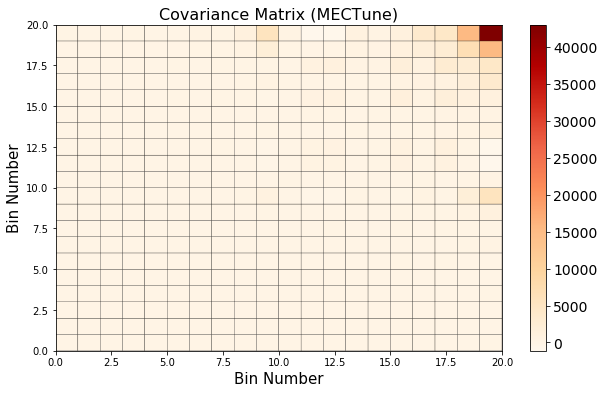

In [17]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, total_noTune_input_cov, cmap='OrRd', edgecolors='k')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
#if pot: 
#    cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

plt.xlim(bins[0], bins[-1])
plt.ylim(bins[0], bins[-1])


plt.xlabel("Bin Number", fontsize=15)
plt.ylabel("Bin Number", fontsize=15)

plt.title('Covariance Matrix (MECTune)', fontsize=16)


plt.savefig("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

plt.show()

In [18]:
np.savetxt("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
           total_noTune_input_cov,
           delimiter =", ", 
           fmt ='% s')